In [2]:
import numpy as np
import nengo
from nengo.solvers import LstsqL2, NoSolver
from nengo.utils.matplotlib import rasterplot
from nengo.dists import Uniform
import nengolib
from nengolib.signal import s

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

from nengo_bioneurons import BahlNeuron

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


The "supervisor" is a bioneuron population that is identical to the "bio" population being trained in the network. It's job is to provide a set of training spikes to bio which have similar statistics/dynamics to the recurrent spikes that "bio" would produce if it were working properly. That is, the spikes produced by "bio" (and the corresponding spate-space decode) should, after training, resemble those of the "supervisor". During training, the "supervisor" is fed with spikes representing $u(t)$ and $x(t)$ which correspond to the feedforward and recurrent signals that govern the dynamics of an integrator:

$\dot{\mathbf{x}}(t) = A'\mathbf{x}(t) + B'\mathbf{u}(t) \simeq \mathbf{x}(t) + \tau \mathbf{u}(t)$

where the $\simeq$ denotes that the normal NEF principle 3 description of the signal may not hold for bioneurons whose internal dynamics dominate the synaptic time constant $\tau$. These "supervisor" spikes are sent to "bio", with synaptic weights computed using the procedure described below. If these weights have been trained properly, "supv" should stimulate "bio" with spikes representing $\mathbf{x}(t)$, the ideal signal that "bio" should be sending back to itself in a fully recurrent (unsupervised) network to implement the integrator. 

In the `simulate()` method, "supv" is driven to represent the target signal using the preliminary spike-generating LIF() ensembles labeled "pre_u" and "pre_x". These ensembles connect onto "supv" with synapses placed on the dendritic section(s) specified in the list $secs=['tuft']$ with the associated number of synapses $n_{syn}$. "pre_u" also connects to "bio". All connections from LIF to bioneuron ensembles use the standard nengo decoders, which are computed with least squares solvers `LstsqL2(reg)` using the specified regularization value. The connection from "supv" to "bio" is governed by the decoders $d_{supv-bio}$, and the connection from "bio" to "bio" by $d_{bio-bio}$. Initially these decoders, as well as the readout decoders $d_{supv-out}$ and $d_{bio-out}$, are set to zero.

The first call of `simulate()` generates spikes from "supv" representing $\mathbf{x}(t)$ are collected and smoothed with a lowpass filter $\tau=taus['readout']$. The target signal $\mathbf{x}(t) = \int_0^T \mathbf{u}(t) dt$ is computed using a `nengolib` synapse, `nengo.Connection(u, tar, synapse=1/s)`. Readout decoders are computed from these activities and the appropriately-filtered target using another least squares solver, `d = LstsqL2(reg)(act, tar)`. Regularization of all decoders (feedforard, recurrent, readout), is controlled with a dictionary $reg$. The first call returns $d_{supv-out}$ and $d_{supv-bio}$, which differ only in $reg$.

The second call of `simulate()` feeds the spikes from "supv" into "bio" using synaptic weights computed from $d_{supv-bio}$ and "bio"'s encoders. Now, spikes from "bio" are collected, smoothed, and used to compute readout and recurrent decoders for "bio", $d_{bio-out}$ and $d_{bio-bio}$, which again differ only in $reg$.

The third call of `simulate()` removes the supervisor connection by setting $d_{supv-out}$ to all zeros, then feeds the spikes from "bio" into "bio" using synaptic weights computed from $d_{bio-bio}$ and "bio"'s encoders. The state is probed from "bio" using a nengo probe with the same lowpass readout filter and the readout decoders $d_{bio-out}$.

In [3]:
def simulate_reset(
    d_supv_out,
    d_supv_bio,
    d_bio_out,
    d_bio_bio,
    t=9,
    n_neurons=10,
    n_syns=1,
    sec='tuft',
    taus={'network': 0.1,
          'readout': 0.1},
    regs={'pre_u-bio': 0.1,
          'pre_x-bio': 0.1,
          'bio-bio': 1.0,
          'bio-out': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4},
    encoders=Uniform(-1e0,1e0),
    gain=Uniform(-1e2, 1e2),
    bias=Uniform(-2e-4, 2e-4),
    neuron_type=BahlNeuron(bias_method='weights'),
    verbose=True):
    
    pre_kwargs = dict(
        n_neurons=100,
        dimensions=1,
        max_rates=Uniform(20, 40),
        seed=seeds['es'])
    
    bio_kwargs = dict(
        n_neurons=n_neurons,
        dimensions=1,
        encoders=encoders,
        gain=gain,
        bias=bias,
        neuron_type=neuron_type,
        seed=seeds['es'])
    
    conn_kwargs = dict(
        sec=sec,
        n_syn=n_syns,
        syn_type='ExpSyn',
        tau_list=[taus['network']],
        synapse=taus['network'],
        seed=seeds['cs'])
        
    def make_model(sign):
        with nengo.Network(seed=seeds['ns']) as model:
            u = nengo.Node(output = lambda t: sign*(t<=1))
            pre_u = nengo.Ensemble(**pre_kwargs)
            pre_x = nengo.Ensemble(**pre_kwargs)
            supv = nengo.Ensemble(**bio_kwargs)
            bio = nengo.Ensemble(**bio_kwargs)

            nengo.Connection(u, pre_u, synapse=None, seed=seeds['cs'])
            nengo.Connection(u, pre_x, synapse=1/s, seed=seeds['cs'])
            # feed u into supv and bio
            nengo.Connection(pre_u, supv,
                transform=taus['network'],
                solver=LstsqL2(reg=regs['pre_u-bio']),
                **conn_kwargs)
            nengo.Connection(pre_u, bio,
                transform=taus['network'],
                solver=LstsqL2(reg=regs['pre_u-bio']),
                **conn_kwargs)
            # feed x into supervisor
            nengo.Connection(pre_x, supv, solver=LstsqL2(reg=regs['pre_x-bio']), **conn_kwargs)
            # feed x from supv to bio
            nengo.Connection(supv, bio, solver=NoSolver(d_supv_bio), **conn_kwargs)      
            # feed x from bio to bio
            nengo.Connection(bio, bio, solver=NoSolver(d_bio_bio), **conn_kwargs)

            model.p_u = nengo.Probe(u, synapse=None)
            model.p_target = nengo.Probe(u, synapse=1/s)
            model.p_act_supv = nengo.Probe(supv.neurons, synapse=None)
            model.p_act_bio = nengo.Probe(bio.neurons, synapse=None)
            model.p_supv = nengo.Probe(supv, synapse=taus['readout'], solver=NoSolver(d_supv_out))
            model.p_bio = nengo.Probe(bio, synapse=taus['readout'], solver=NoSolver(d_bio_out))
            
        return model

    # simulate twice with sign = +1, -1
    model_p = make_model(+1.0)
    with nengo.Simulator(model_p, seed=seeds['ss']) as sim:
        sim.run(t)
    target_p = nengo.Lowpass(taus['readout']).filt(sim.data[model_p.p_target])
    spikes_supv_p = sim.data[model_p.p_act_supv]
    spikes_bio_p = sim.data[model_p.p_act_bio]
    act_supv_p = nengo.Lowpass(taus['readout']).filt(spikes_supv_p)
    act_bio_p = nengo.Lowpass(taus['readout']).filt(spikes_bio_p)
    xhat_supv_p = sim.data[model_p.p_supv]
    xhat_bio_p = sim.data[model_p.p_bio]
    del model_p
    
    model_n = make_model(-1.0)
    with nengo.Simulator(model_n, seed=seeds['ss']) as sim:
        sim.run(t)
    target_n = nengo.Lowpass(taus['readout']).filt(sim.data[model_n.p_target])
    spikes_supv_n = sim.data[model_n.p_act_supv]
    spikes_bio_n = sim.data[model_n.p_act_bio]
    act_supv_n = nengo.Lowpass(taus['readout']).filt(spikes_supv_n)
    act_bio_n = nengo.Lowpass(taus['readout']).filt(spikes_bio_n)   
    xhat_supv_n = sim.data[model_n.p_supv]
    xhat_bio_n = sim.data[model_n.p_bio]
    del model_n
    
    times = np.arange(0, 2*t, 0.001)
    target = np.vstack((target_p, target_n))
    spikes_supv = np.vstack((spikes_supv_p, spikes_supv_n))
    spikes_bio = np.vstack((spikes_bio_p, spikes_bio_n))
    act_supv = np.vstack((act_supv_p, act_supv_n))
    act_bio = np.vstack((act_bio_p, act_bio_n))
    xhat_supv = np.vstack((xhat_supv_p, xhat_supv_n))
    xhat_bio = np.vstack((xhat_bio_p, xhat_bio_n))
    
    nrmse_supv = nengolib.signal.nrmse(xhat_supv, target=target)
    nrmse_bio = nengolib.signal.nrmse(xhat_bio, target=target)

    if verbose:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
        rasterplot(times, spikes_supv, ax=ax1)
        ax1.set(xlabel='time', ylabel='neuron')
        sns.distplot(np.ravel(act_supv), ax=ax2)
        ax2.set(xlim=((1, 50)), ylim=((0, 0.05)), xlabel='activity', ylabel='frequency')
        ax3.plot(times, target, label='target', linestyle='--')
        ax3.plot(times, xhat_supv, alpha=0.5, label='supv')
        ax3.set(xlabel='time', ylabel='$x$', title='nrmse=%.3f'%nrmse_supv)
        ax3.legend()
        fig.suptitle('supervisor')
        plt.tight_layout()
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
        rasterplot(times, spikes_bio, ax=ax1)
        ax1.set(xlabel='time', ylabel='neuron')
        sns.distplot(np.ravel(act_bio), ax=ax2)
        ax2.set(xlim=((1, 50)), ylim=((0, 0.05)), xlabel='activity', ylabel='frequency')
        ax3.plot(times, target, label='target', linestyle='--')
        ax3.plot(times, xhat_bio, alpha=0.5, label='bio')
        ax3.set(xlabel='time', ylabel='$x$', title='nrmse=%.3f'%nrmse_bio)
        ax3.legend()
        fig.suptitle('bio')
        plt.tight_layout()
        
        plt.show()

    d_supv_out_new = LstsqL2(reg=regs['bio-out'])(act_supv, target)[0]
    d_supv_bio_new = LstsqL2(reg=regs['bio-bio'])(act_supv, target)[0]
    d_bio_out_new = LstsqL2(reg=regs['bio-out'])(act_bio, target)[0]
    d_bio_bio_new = LstsqL2(reg=regs['bio-bio'])(act_bio, target)[0]
    
    return d_supv_out_new, d_supv_bio_new, d_bio_out_new, d_bio_bio_new

### Remove bias so that tuning curves form a 'Y' at $x=0$

Building finished in 0:00:02.                                                   
Simulating finished in 0:40:42.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:34:54.                                                 
full supervision
Building finished in 0:00:02.                                                   
Simulating finished in 0:37:03.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:33:30.                                                 


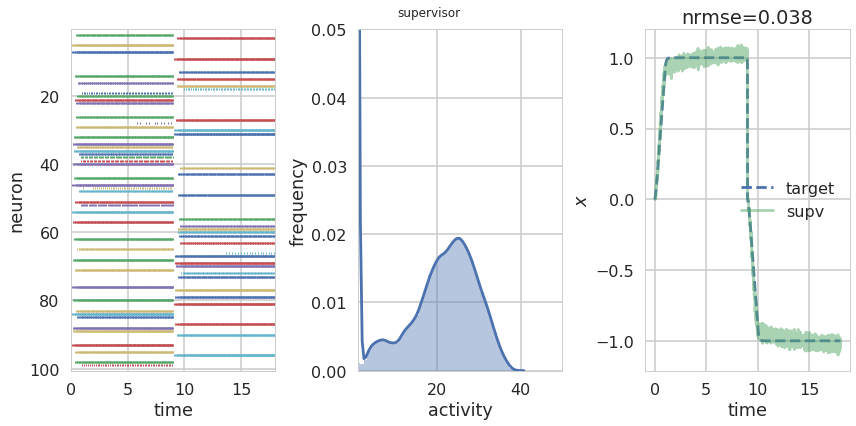

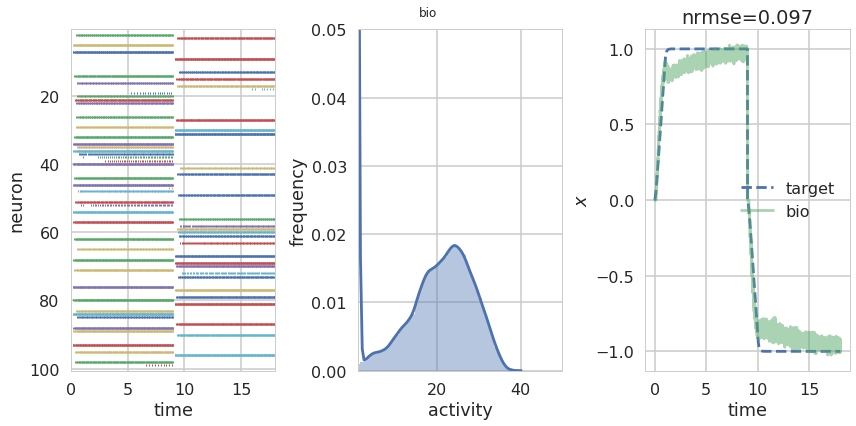

full recurrence
Building finished in 0:00:02.                                                   
Simulating finished in 0:50:46.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:42:21.                                                 


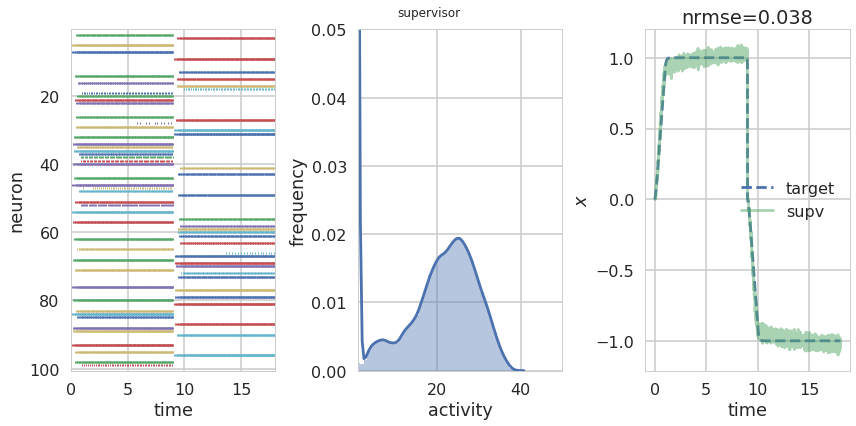

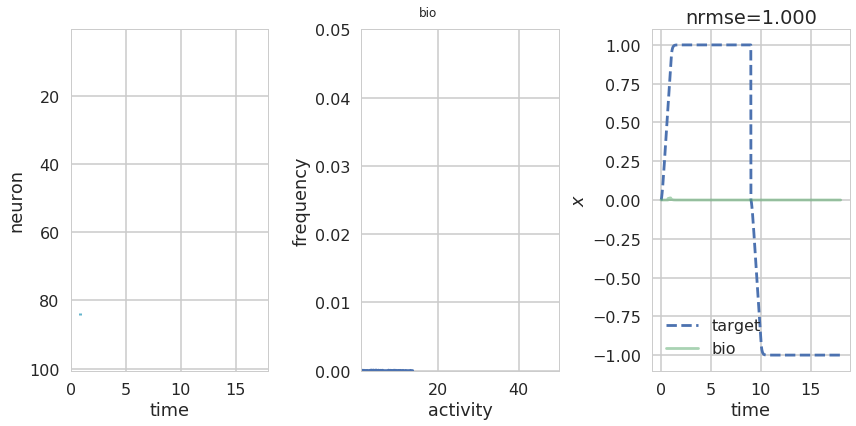

In [12]:
n_neurons = 100
t = 9
bias = Uniform(0, 0)

d_supv_out_init = np.zeros((n_neurons, 1))
d_supv_bio_init = np.zeros((n_neurons, 1))
d_bio_out_init = np.zeros((n_neurons, 1))
d_bio_bio_init = np.zeros((n_neurons, 1))

d_supv_out, d_supv_bio, _, _ = simulate_reset(
    d_supv_out_init,
    d_supv_bio_init,
    d_bio_out_init,
    d_bio_bio_init,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    verbose=False)

print "full supervision"
_, _, d_bio_out, d_bio_bio = simulate_reset(
    d_supv_out,
    d_supv_bio,
    d_supv_out,
    d_bio_bio_init,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    verbose=True)

print "full recurrence"
_, _, _, _ = simulate_reset(
    d_supv_out,
    d_supv_bio_init,
    d_bio_out,
    d_bio_bio,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    verbose=True)

sliiiightly more bias...

Building finished in 0:00:02.                                                   
Simulating finished in 0:45:07.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:50:55.                                                 
full supervision
Building finished in 0:00:02.                                                   
Simulating finished in 0:52:06.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:52:17.                                                 


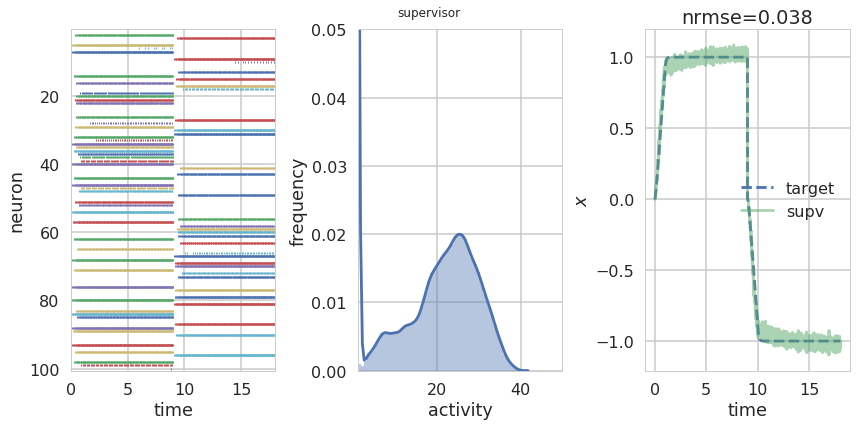

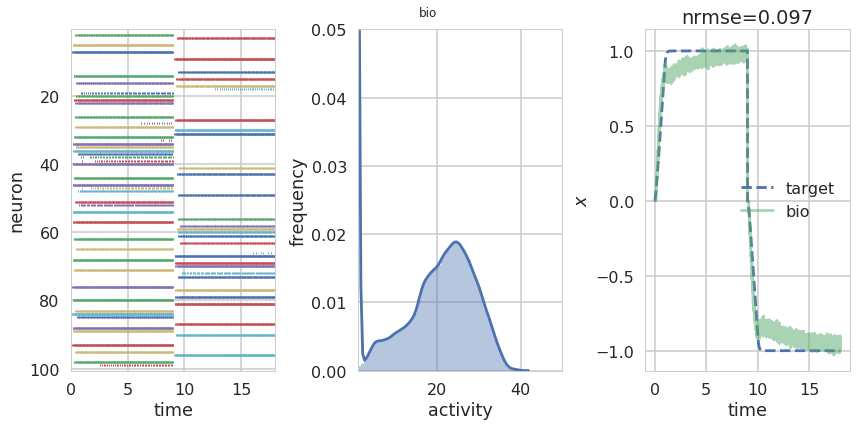

full recurrence
Building finished in 0:00:02.                                                   
Simulating finished in 0:55:41.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:38:16.                                                 


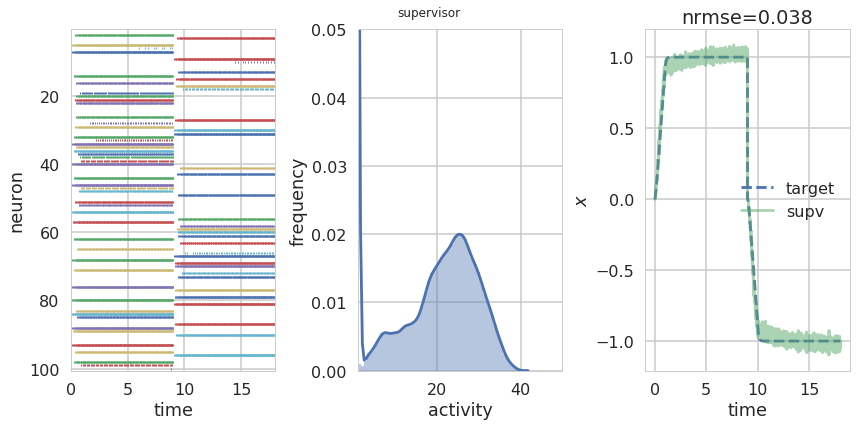

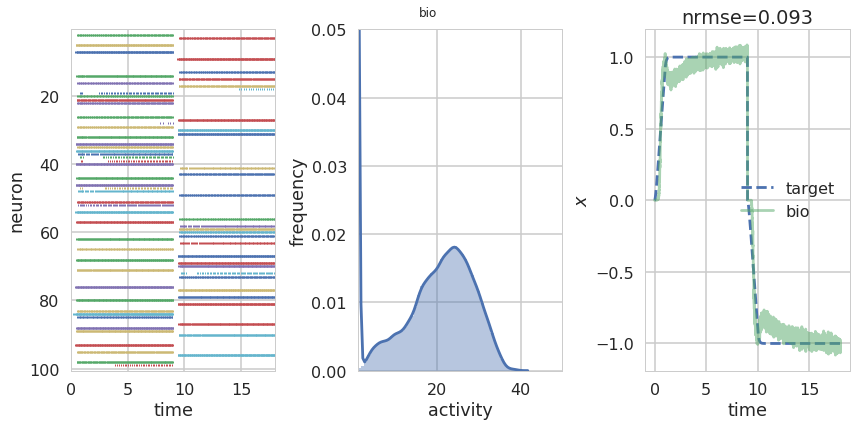

In [15]:
n_neurons = 100
t = 9
bias = Uniform(-3e-5, 3e-5)

d_supv_out_init = np.zeros((n_neurons, 1))
d_supv_bio_init = np.zeros((n_neurons, 1))
d_bio_out_init = np.zeros((n_neurons, 1))
d_bio_bio_init = np.zeros((n_neurons, 1))

d_supv_out, d_supv_bio, _, _ = simulate_reset(
    d_supv_out_init,
    d_supv_bio_init,
    d_bio_out_init,
    d_bio_bio_init,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    verbose=False)

print "full supervision"
_, _, d_bio_out, d_bio_bio = simulate_reset(
    d_supv_out,
    d_supv_bio,
    d_supv_out,
    d_bio_bio_init,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    verbose=True)

print "full recurrence"
_, _, _, _ = simulate_reset(
    d_supv_out,
    d_supv_bio_init,
    d_bio_out,
    d_bio_bio,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    verbose=True)

Building finished in 0:00:02.                                                   
Simulating finished in 0:38:45.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:38:43.                                                 
full supervision
Building finished in 0:00:02.                                                   
Simulating finished in 0:40:27.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:40:03.                                                 


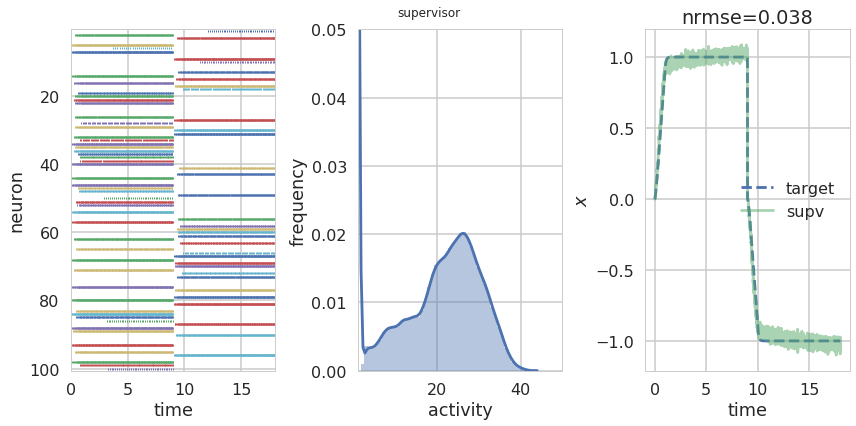

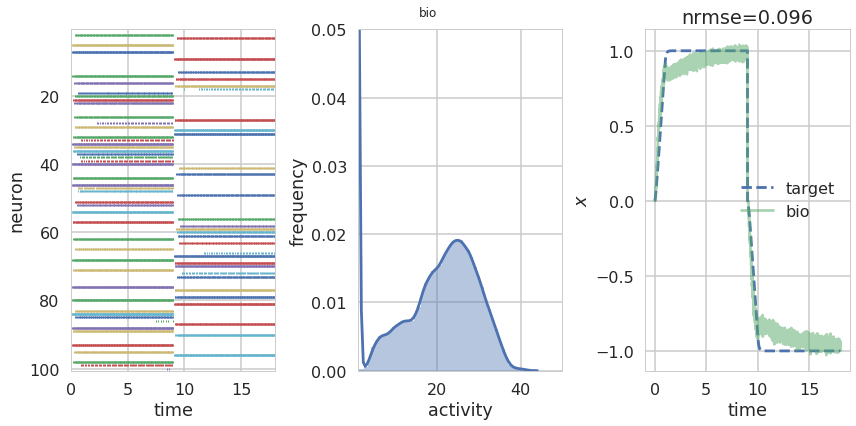

full recurrence
Building finished in 0:00:02.                                                   
Simulating finished in 0:58:44.                                                 
Building finished in 0:00:03.                                                   
Simulating finished in 1:03:29.                                                 


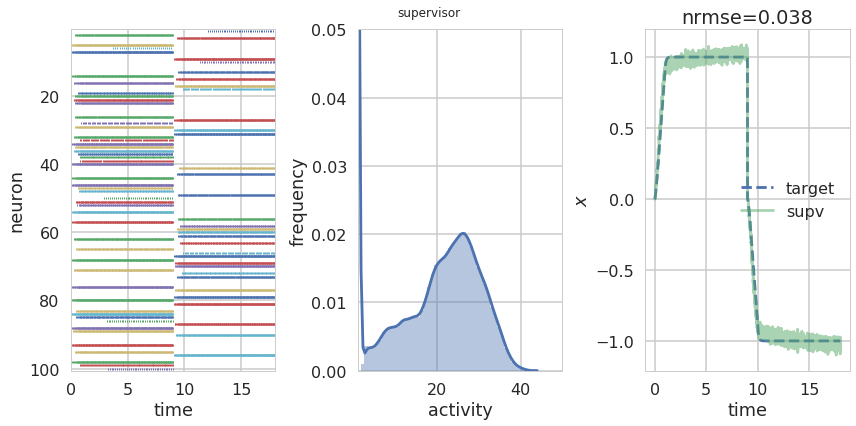

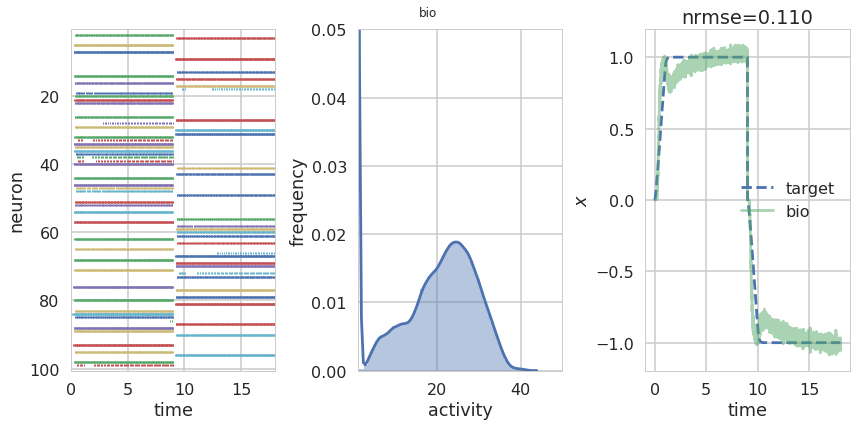

In [16]:
n_neurons = 100
t = 9
bias = Uniform(-7e-5, 7e-5)

d_supv_out_init = np.zeros((n_neurons, 1))
d_supv_bio_init = np.zeros((n_neurons, 1))
d_bio_out_init = np.zeros((n_neurons, 1))
d_bio_bio_init = np.zeros((n_neurons, 1))

d_supv_out, d_supv_bio, _, _ = simulate_reset(
    d_supv_out_init,
    d_supv_bio_init,
    d_bio_out_init,
    d_bio_bio_init,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    verbose=False)

print "full supervision"
_, _, d_bio_out, d_bio_bio = simulate_reset(
    d_supv_out,
    d_supv_bio,
    d_supv_out,
    d_bio_bio_init,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    verbose=True)

print "full recurrence"
_, _, _, _ = simulate_reset(
    d_supv_out,
    d_supv_bio_init,
    d_bio_out,
    d_bio_bio,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    verbose=True)

Seems to have worked! Try saving the decoders, reloading them, and testing on a method  where "supv" is completely removed, to ensure I'm not accidentally cheating and still supervising "bio" somehow.

In [17]:
np.savez('data/supvervise_integrator_7e-5bias.npz',
    d_bio_out=d_bio_out,
    d_bio_bio=d_bio_bio)

In [4]:
def test(
    d_bio_out,
    d_bio_bio,
    t=9,
    n_neurons=10,
    n_syns=1,
    sign=+1,
    sec='tuft',
    taus={'network': 0.1,
          'readout': 0.1},
    regs={'pre_u-bio': 0.1,
          'pre_x-bio': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4},
    encoders=Uniform(-1e0,1e0),
    gain=Uniform(-1e2, 1e2),
    bias=Uniform(-2e-4, 2e-4),
    neuron_type=BahlNeuron(bias_method='weights'),
    verbose=True):
    
    pre_kwargs = dict(
        n_neurons=100,
        dimensions=1,
        max_rates=Uniform(20, 40),
        seed=seeds['es'])
    
    bio_kwargs = dict(
        n_neurons=n_neurons,
        dimensions=1,
        encoders=encoders,
        gain=gain,
        bias=bias,
        neuron_type=neuron_type,
        seed=seeds['es'])
    
    conn_kwargs = dict(
        sec=sec,
        n_syn=n_syns,
        syn_type='ExpSyn',
        tau_list=[taus['network']],
        synapse=taus['network'],
        seed=seeds['cs'])
        
    with nengo.Network(seed=seeds['ns']) as model:
        u = nengo.Node(output = lambda t: sign*(t<=1))
        pre_u = nengo.Ensemble(**pre_kwargs)
        bio = nengo.Ensemble(**bio_kwargs)

        nengo.Connection(u, pre_u, synapse=None, seed=seeds['cs'])
        nengo.Connection(pre_u, bio,
            transform=taus['network'],
            solver=LstsqL2(reg=regs['pre_u-bio']),
            **conn_kwargs)     
        nengo.Connection(bio, bio, solver=NoSolver(d_bio_bio), **conn_kwargs)

        p_target = nengo.Probe(u, synapse=1/s)
        p_act_bio = nengo.Probe(bio.neurons, synapse=None)
        p_bio = nengo.Probe(bio, synapse=taus['readout'], solver=NoSolver(d_bio_out))
            
    with nengo.Simulator(model, seed=seeds['ss']) as sim:
        sim.run(t)
    target = nengo.Lowpass(taus['readout']).filt(sim.data[p_target])
    spikes_bio = sim.data[p_act_bio]
    act_bio = nengo.Lowpass(taus['readout']).filt(spikes_bio)
    xhat_bio = sim.data[p_bio]
    nrmse_bio = nengolib.signal.nrmse(xhat_bio, target=target)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
    rasterplot(sim.trange(), spikes_bio, ax=ax1)
    ax1.set(xlabel='time', ylabel='neuron')
    sns.distplot(np.ravel(act_bio), ax=ax2)
    ax2.set(xlim=((1, 50)), ylim=((0, 0.05)), xlabel='activity', ylabel='frequency')
    ax3.plot(sim.trange(), target, label='target', linestyle='--')
    ax3.plot(sim.trange(), xhat_bio, alpha=0.5, label='bio')
    ax3.set(xlabel='time', ylabel='$x$', title='nrmse=%.3f'%nrmse_bio)
    ax3.legend()
    fig.suptitle('bio')
    plt.tight_layout()
    plt.show()

Building finished in 0:00:01.                                                   
Simulating finished in 0:15:08.                                                 


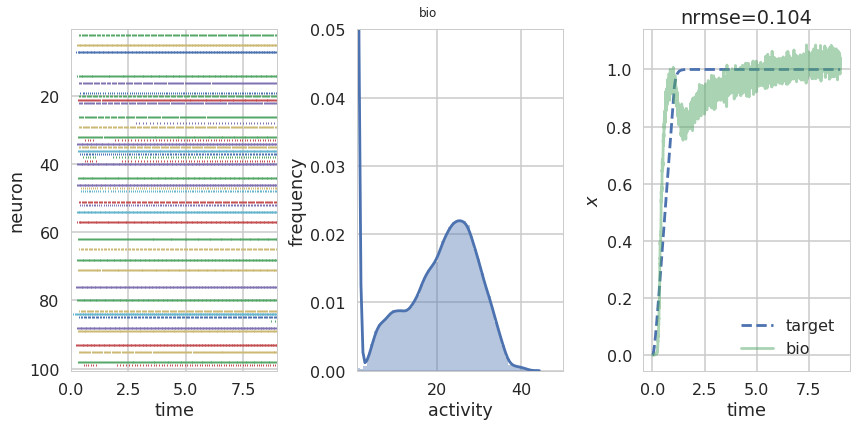

Building finished in 0:00:01.                                                   
Simulating finished in 0:19:16.                                                 


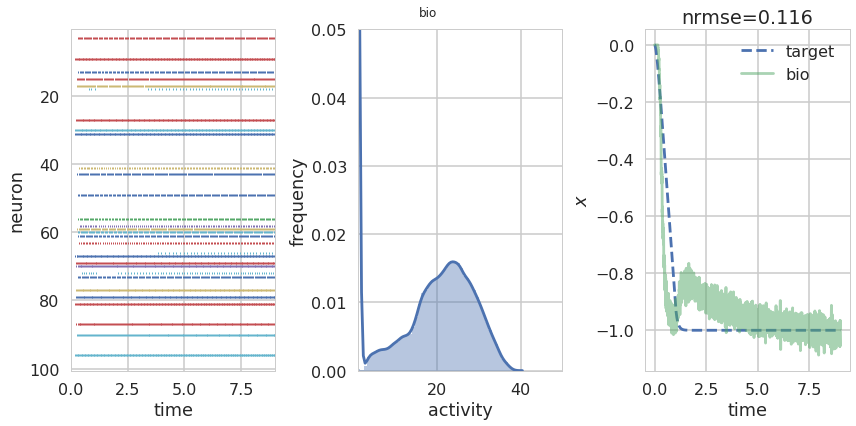

In [4]:
d_bio_out_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_out']
d_bio_bio_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_bio']
bias = Uniform(-7e-5, 7e-5)
n_neurons = 100
t = 9

test(
    d_bio_out_good,
    d_bio_bio_good,
    sign=+1,
    n_neurons=n_neurons,
    t=t,
    bias=bias)

test(
    d_bio_out_good,
    d_bio_bio_good,
    sign=-1,
    n_neurons=n_neurons,
    t=t,
    bias=bias)

### Add noise during testing to see if the representation decays over time

In [5]:
def test_noise(
    d_bio_out,
    d_bio_bio,
    inhibit_weights,
    t=9,
    n_neurons=10,
    n_syns=1,
    sign=+1,
    noise_freq=1,
    noise_amp=1,
    sec='tuft',
    taus={'network': 0.1,
          'readout': 0.1},
    regs={'pre_u-bio': 0.1,
          'pre_x-bio': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4},
    encoders=Uniform(-1e0,1e0),
    gain=Uniform(-1e2, 1e2),
    bias=Uniform(-2e-4, 2e-4),
    neuron_type=BahlNeuron(bias_method='weights'),
    verbose=True):
    
    pre_kwargs = dict(
        n_neurons=100,
        dimensions=1,
        max_rates=Uniform(20, 40),
        seed=seeds['es'])
    
    bio_kwargs = dict(
        n_neurons=n_neurons,
        dimensions=1,
        encoders=encoders,
        gain=gain,
        bias=bias,
        neuron_type=neuron_type,
        seed=seeds['es'])
    
    conn_kwargs = dict(
        sec=sec,
        n_syn=n_syns,
        syn_type='ExpSyn',
        tau_list=[taus['network']],
        synapse=taus['network'],
        seed=seeds['cs'])
        
    with nengo.Network(seed=seeds['ns']) as model:
        u = nengo.Node(output = lambda t: sign*(t<=1))
        noise = nengo.Node(nengo.processes.WhiteSignal(
            period=100, high=noise_freq, rms=noise_amp, seed=seeds['ss']))
        pre_u = nengo.Ensemble(**pre_kwargs)
        pre_noise = nengo.Ensemble(**pre_kwargs)
        bio = nengo.Ensemble(**bio_kwargs)

        nengo.Connection(u, pre_u, synapse=None, seed=seeds['cs'])
        nengo.Connection(noise, pre_noise, synapse=None, seed=seeds['cs'])
        nengo.Connection(pre_u, bio,
            transform=taus['network'],
            solver=LstsqL2(reg=regs['pre_u-bio']),
            **conn_kwargs)
        nengo.Connection(pre_noise, bio,
            syn_weights=inhibit_weights,
            **conn_kwargs)
        nengo.Connection(bio, bio, solver=NoSolver(d_bio_bio), **conn_kwargs)

        p_target = nengo.Probe(u, synapse=1/s)
        p_act_bio = nengo.Probe(bio.neurons, synapse=None)
        p_bio = nengo.Probe(bio, synapse=taus['readout'], solver=NoSolver(d_bio_out))
            
    with nengo.Simulator(model, seed=seeds['ss']) as sim:
        sim.run(t)
    target = nengo.Lowpass(taus['readout']).filt(sim.data[p_target])
    spikes_bio = sim.data[p_act_bio]
    act_bio = nengo.Lowpass(taus['readout']).filt(spikes_bio)
    xhat_bio = sim.data[p_bio]
    nrmse_bio = nengolib.signal.nrmse(xhat_bio, target=target)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
    rasterplot(sim.trange(), spikes_bio, ax=ax1)
    ax1.set(xlabel='time', ylabel='neuron')
    sns.distplot(np.ravel(act_bio), ax=ax2)
    ax2.set(xlim=((1, 50)), ylim=((0, 0.05)), xlabel='activity', ylabel='frequency')
    ax3.plot(sim.trange(), target, label='target', linestyle='--')
    ax3.plot(sim.trange(), xhat_bio, alpha=0.5, label='bio')
    ax3.set(xlabel='time', ylabel='$x$', title='nrmse=%.3f'%nrmse_bio)
    ax3.legend()
    fig.suptitle('bio')
    plt.tight_layout()
    plt.show()

Building finished in 0:00:01.                                                   
Simulating finished in 0:22:56.                                                 


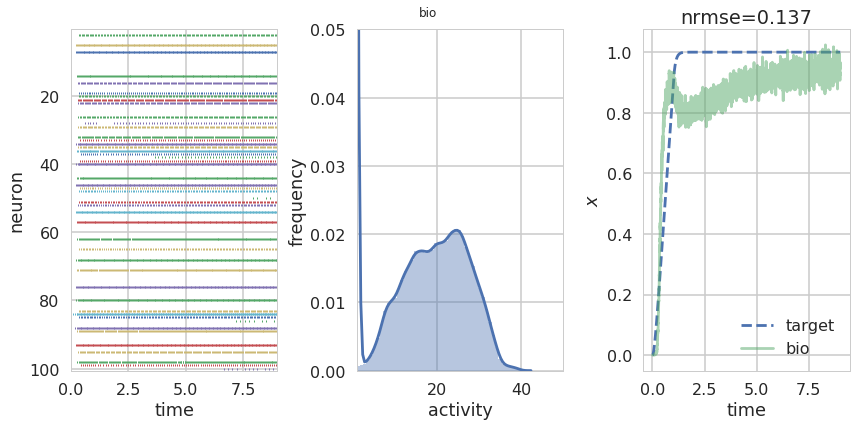

Building finished in 0:00:01.                                                   
Simulating finished in 0:21:30.                                                 


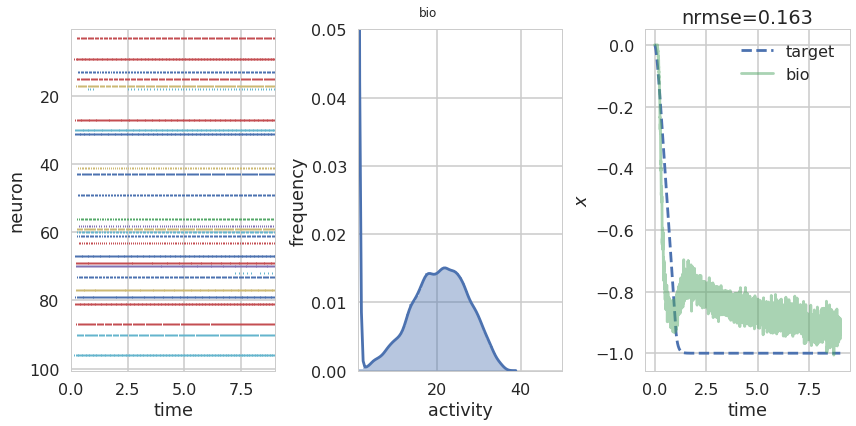

In [7]:
d_bio_out_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_out']
d_bio_bio_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_bio']
bias = Uniform(-7e-5, 7e-5)
n_neurons = 100
t = 9

inhibit_weights = np.random.RandomState(seed=1).uniform(
    -1e-4, 1e-4, size=((n_neurons, 100, 1)))

test_noise(
    d_bio_out_good,
    d_bio_bio_good,
    sign=+1,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    inhibit_weights=inhibit_weights)

test_noise(
    d_bio_out_good,
    d_bio_bio_good,
    sign=-1,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    inhibit_weights=inhibit_weights)

Building finished in 0:00:02.                                                   
Simulating finished in 0:23:25.                                                 


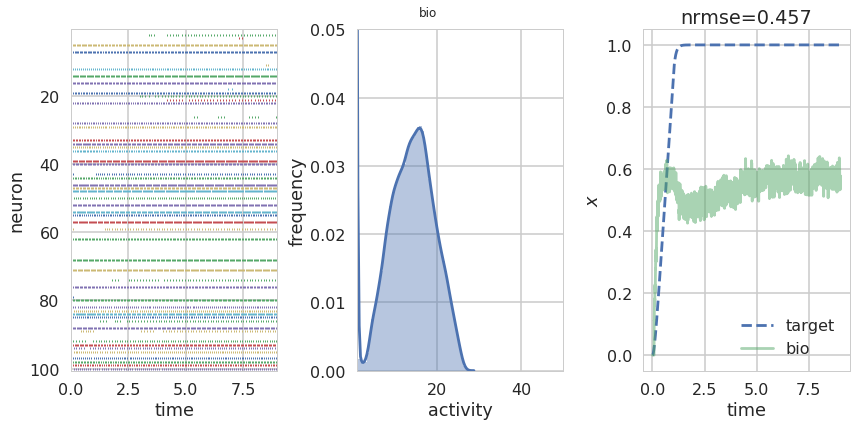

Building finished in 0:00:01.                                                   
Simulating finished in 0:21:59.                                                 


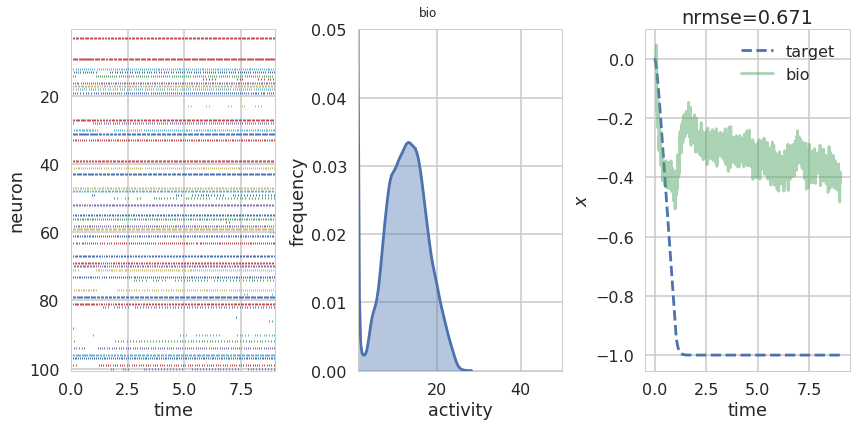

In [8]:
d_bio_out_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_out']
d_bio_bio_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_bio']
bias = Uniform(-7e-5, 7e-5)
n_neurons = 100
t = 9

inhibit_weights = np.random.RandomState(seed=1).uniform(
    -1e-3, 1e-3, size=((n_neurons, 100, 1)))

test_noise(
    d_bio_out_good,
    d_bio_bio_good,
    sign=+1,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    inhibit_weights=inhibit_weights)

test_noise(
    d_bio_out_good,
    d_bio_bio_good,
    sign=-1,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    inhibit_weights=inhibit_weights)

Building finished in 0:00:01.                                                   
Simulating finished in 0:22:55.                                                 


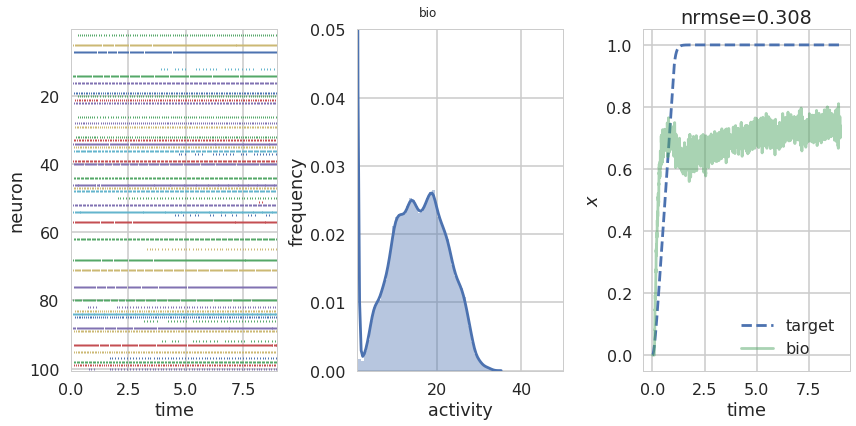

Building finished in 0:00:01.                                                   
Simulating finished in 0:23:49.                                                 


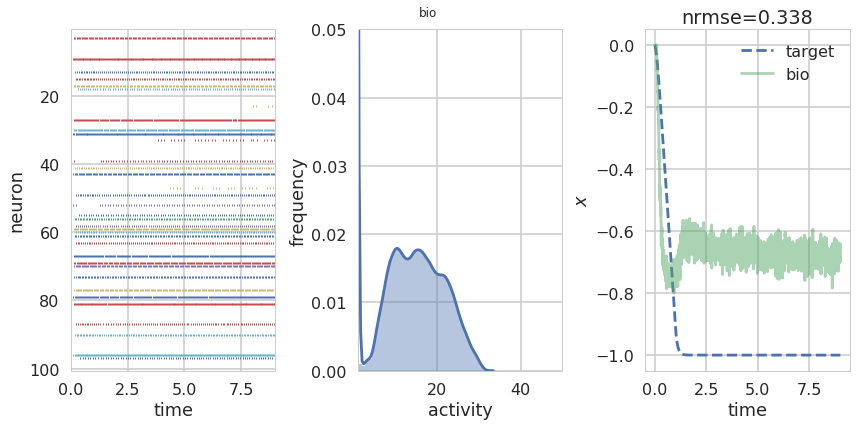

In [9]:
d_bio_out_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_out']
d_bio_bio_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_bio']
bias = Uniform(-7e-5, 7e-5)
n_neurons = 100
t = 9

inhibit_weights = np.random.RandomState(seed=1).uniform(
    -5e-4, 5e-4, size=((n_neurons, 100, 1)))

test_noise(
    d_bio_out_good,
    d_bio_bio_good,
    sign=+1,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    inhibit_weights=inhibit_weights)

test_noise(
    d_bio_out_good,
    d_bio_bio_good,
    sign=-1,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    inhibit_weights=inhibit_weights)

Stimulate noise_lif with white_noise instead of constant 0

Building finished in 0:00:01.                                                   
Simulating finished in 0:23:57.                                                 


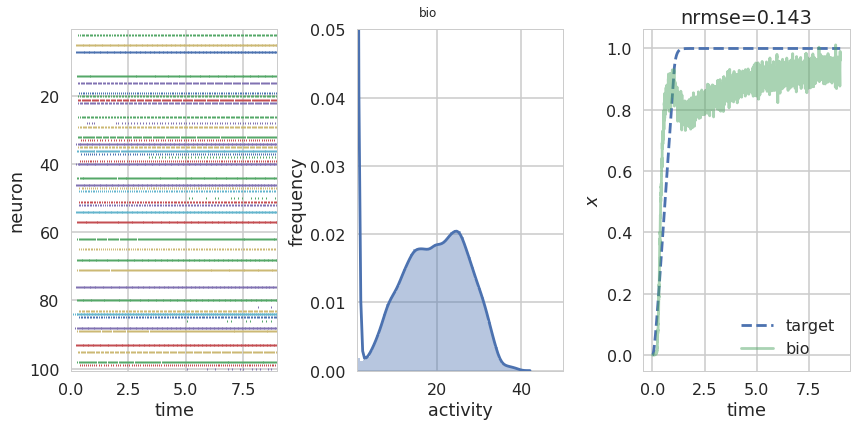

Building finished in 0:00:01.                                                   
Simulating finished in 0:22:14.                                                 


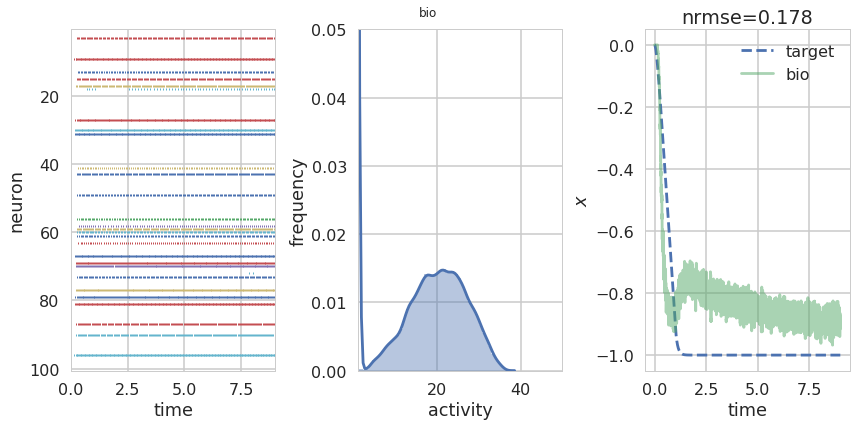

In [14]:
d_bio_out_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_out']
d_bio_bio_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_bio']
bias = Uniform(-7e-5, 7e-5)
n_neurons = 100
t = 9

inhibit_weights = np.random.RandomState(seed=1).uniform(
    -1e-4, 1e-4, size=((n_neurons, 100, 1)))

test_noise(
    d_bio_out_good,
    d_bio_bio_good,
    sign=+1,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    inhibit_weights=inhibit_weights)

test_noise(
    d_bio_out_good,
    d_bio_bio_good,
    sign=-1,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    inhibit_weights=inhibit_weights)

Building finished in 0:00:01.                                                   


/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


Simulating finished in 0:16:27.                                                 


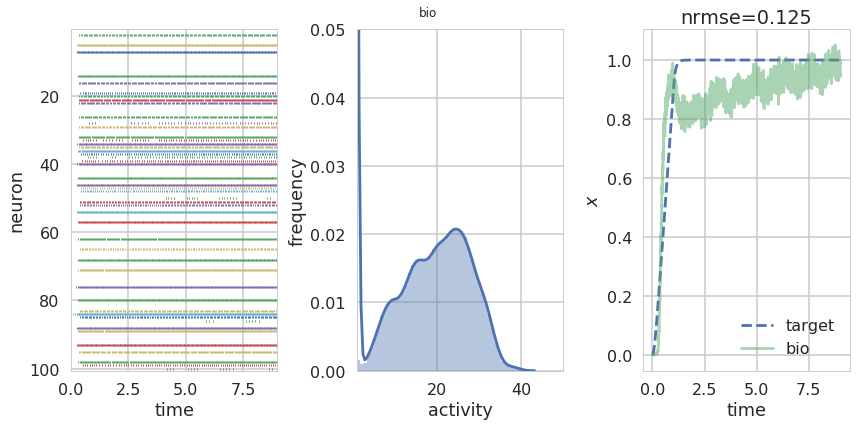

Building finished in 0:00:01.                                                   
Simulating finished in 0:04:25.                                                 


KeyboardInterrupt: 

In [3]:
d_bio_out_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_out']
d_bio_bio_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_bio']
bias = Uniform(-7e-5, 7e-5)
n_neurons = 100
t = 9
noise_freq = 1
noise_amp = 1

inhibit_weights = np.random.RandomState(seed=1).uniform(
    -5e-5, 5e-5, size=((n_neurons, 100, 1)))

test_noise(
    d_bio_out_good,
    d_bio_bio_good,
    sign=+1,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    noise_freq=noise_freq,
    noise_amp=noise_amp,
    inhibit_weights=inhibit_weights)

Building finished in 0:00:01.                                                   


/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


Simulating finished in 0:17:17.                                                 


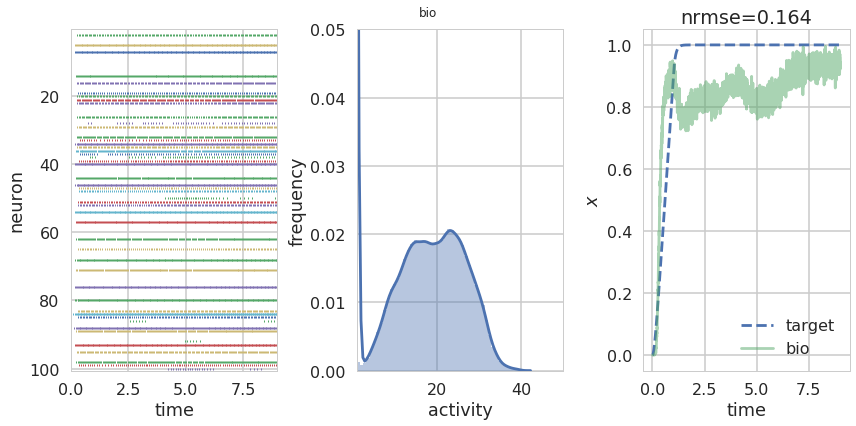

In [3]:
d_bio_out_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_out']
d_bio_bio_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_bio']
bias = Uniform(-7e-5, 7e-5)
n_neurons = 100
t = 9
noise_freq = 0.3
noise_amp = 1

inhibit_weights = np.random.RandomState(seed=1).uniform(
    -1e-4, 1e-4, size=((n_neurons, 100, 1)))

test_noise(
    d_bio_out_good,
    d_bio_bio_good,
    sign=+1,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    noise_freq=noise_freq,
    noise_amp=noise_amp,
    inhibit_weights=inhibit_weights)

Building finished in 0:00:01.                                                   
Simulating finished in 0:18:20.                                                 


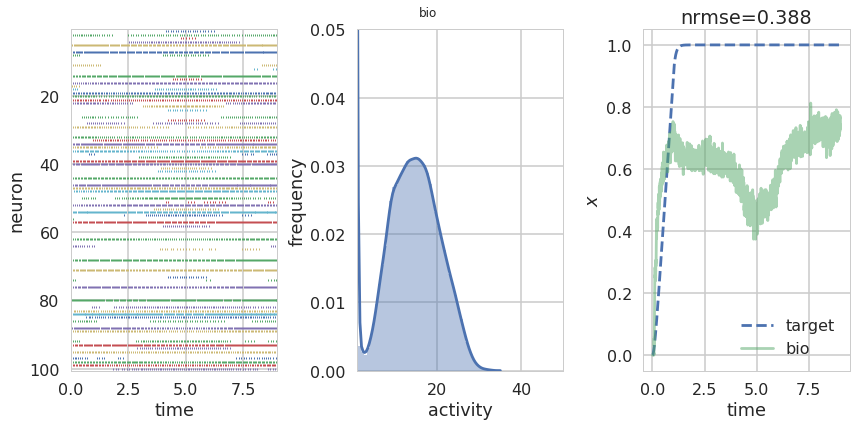

In [4]:
d_bio_out_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_out']
d_bio_bio_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_bio']
bias = Uniform(-7e-5, 7e-5)
n_neurons = 100
t = 9
noise_freq = 0.1
noise_amp = 1

inhibit_weights = np.random.RandomState(seed=1).uniform(
    -5e-4, 5e-4, size=((n_neurons, 100, 1)))

test_noise(
    d_bio_out_good,
    d_bio_bio_good,
    sign=+1,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    noise_freq=noise_freq,
    noise_amp=noise_amp,
    inhibit_weights=inhibit_weights)

Building finished in 0:00:01.                                                   


/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


Simulating finished in 0:16:27.                                                 


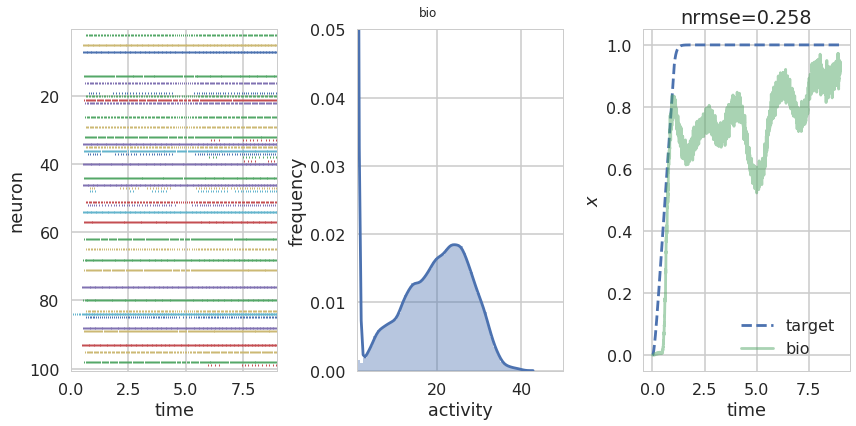

In [3]:
d_bio_out_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_out']
d_bio_bio_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_bio']
bias = Uniform(-7e-5, 7e-5)
n_neurons = 100
t = 9
noise_freq = 0.5
noise_amp = 1

inhibit_weights = np.random.RandomState(seed=1).uniform(
    -1e-5, -1e-5, size=((n_neurons, 100, 1)))

test_noise(
    d_bio_out_good,
    d_bio_bio_good,
    sign=+1,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    noise_freq=noise_freq,
    noise_amp=noise_amp,
    inhibit_weights=inhibit_weights)

Building finished in 0:00:01.                                                   
Simulating finished in 0:17:12.                                                 


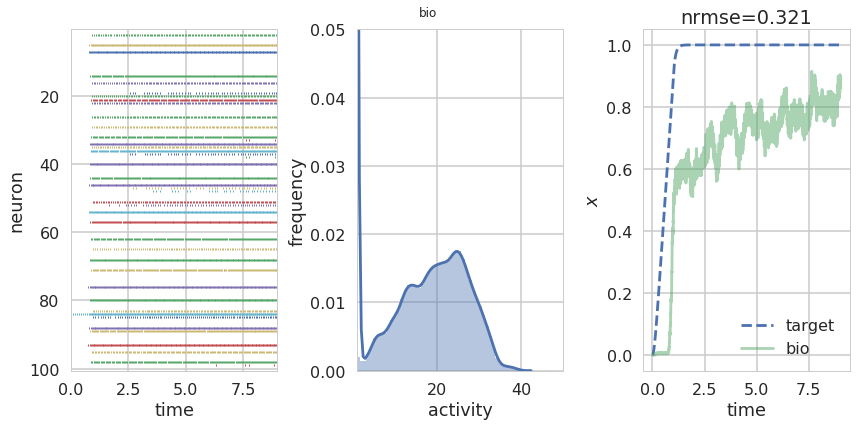

In [4]:
d_bio_out_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_out']
d_bio_bio_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_bio']
bias = Uniform(-7e-5, 7e-5)
n_neurons = 100
t = 9
noise_freq = 5
noise_amp = 1

inhibit_weights = np.random.RandomState(seed=1).uniform(
    -1e-5, -1e-5, size=((n_neurons, 100, 1)))

test_noise(
    d_bio_out_good,
    d_bio_bio_good,
    sign=+1,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    noise_freq=noise_freq,
    noise_amp=noise_amp,
    inhibit_weights=inhibit_weights)

### Copy the recurrent "bio" ensemble, simulate it identically to "bio", and use it to inhibit "bio"

In [6]:
def test_inh_fb(
    d_bio_out,
    d_bio_bio,
    inhibit_weights,
    t=9,
    n_neurons=10,
    n_syns=1,
    sign=+1,
    sec='tuft',
    taus={'network': 0.1,
          'readout': 0.1},
    regs={'pre_u-bio': 0.1,
          'pre_x-bio': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4},
    encoders=Uniform(-1e0,1e0),
    gain=Uniform(-1e2, 1e2),
    bias=Uniform(-2e-4, 2e-4),
    neuron_type=BahlNeuron(bias_method='weights'),
    verbose=True):
    
    pre_kwargs = dict(
        n_neurons=100,
        dimensions=1,
        max_rates=Uniform(20, 40),
        seed=seeds['es'])
    
    bio_kwargs = dict(
        n_neurons=n_neurons,
        dimensions=1,
        encoders=encoders,
        gain=gain,
        bias=bias,
        neuron_type=neuron_type,
        seed=seeds['es'])
    
    conn_kwargs = dict(
        sec=sec,
        n_syn=n_syns,
        syn_type='ExpSyn',
        tau_list=[taus['network']],
        synapse=taus['network'],
        seed=seeds['cs'])
        
    with nengo.Network(seed=seeds['ns']) as model:
        u = nengo.Node(output = lambda t: sign*(t<=1))
        pre_u = nengo.Ensemble(**pre_kwargs)
        bio = nengo.Ensemble(**bio_kwargs)
        bio_inh = nengo.Ensemble(**bio_kwargs)

        nengo.Connection(u, pre_u, synapse=None, seed=seeds['cs'])
        nengo.Connection(pre_u, bio,
            transform=taus['network'],
            solver=LstsqL2(reg=regs['pre_u-bio']),
            **conn_kwargs)
        nengo.Connection(bio, bio, solver=NoSolver(d_bio_bio), **conn_kwargs)
        nengo.Connection(pre_u, bio_inh,
            transform=taus['network'],
            solver=LstsqL2(reg=regs['pre_u-bio']),
            **conn_kwargs)
        nengo.Connection(bio_inh, bio_inh, solver=NoSolver(d_bio_bio), **conn_kwargs)
        nengo.Connection(bio_inh, bio, syn_weights=inhibit_weights, **conn_kwargs)

        
        p_target = nengo.Probe(u, synapse=1/s)
        p_act_bio = nengo.Probe(bio.neurons, synapse=None)
        p_act_bio_inh = nengo.Probe(bio_inh.neurons, synapse=None)
        p_bio = nengo.Probe(bio, synapse=taus['readout'], solver=NoSolver(d_bio_out))
        p_bio_inh = nengo.Probe(bio_inh, synapse=taus['readout'], solver=NoSolver(d_bio_out))
            
    with nengo.Simulator(model, seed=seeds['ss']) as sim:
        sim.run(t)
    target = nengo.Lowpass(taus['readout']).filt(sim.data[p_target])
    spikes_bio = sim.data[p_act_bio]
    spikes_bio_inh = sim.data[p_act_bio_inh]
    act_bio = nengo.Lowpass(taus['readout']).filt(spikes_bio)
    act_bio_inh = nengo.Lowpass(taus['readout']).filt(spikes_bio_inh)
    xhat_bio = sim.data[p_bio]
    xhat_bio_inh = sim.data[p_bio_inh]
    nrmse_bio = nengolib.signal.nrmse(xhat_bio, target=target)
    nrmse_bio_inh = nengolib.signal.nrmse(xhat_bio_inh, target=target)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
    rasterplot(sim.trange(), spikes_bio_inh, ax=ax1)
    ax1.set(xlabel='time', ylabel='neuron')
    sns.distplot(np.ravel(act_bio_inh), ax=ax2)
    ax2.set(xlim=((1, 50)), ylim=((0, 0.05)), xlabel='activity', ylabel='frequency')
    ax3.plot(sim.trange(), target, label='target', linestyle='--')
    ax3.plot(sim.trange(), xhat_bio_inh, alpha=0.5, label='bio_inh')
    ax3.set(xlabel='time', ylabel='$x$', title='nrmse=%.3f'%nrmse_bio_inh)
    ax3.legend()
    fig.suptitle('bio_inh')
    plt.tight_layout()
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
    rasterplot(sim.trange(), spikes_bio, ax=ax1)
    ax1.set(xlabel='time', ylabel='neuron')
    sns.distplot(np.ravel(act_bio), ax=ax2)
    ax2.set(xlim=((1, 50)), ylim=((0, 0.05)), xlabel='activity', ylabel='frequency')
    ax3.plot(sim.trange(), target, label='target', linestyle='--')
    ax3.plot(sim.trange(), xhat_bio, alpha=0.5, label='bio')
    ax3.set(xlabel='time', ylabel='$x$', title='nrmse=%.3f'%nrmse_bio)
    ax3.legend()
    fig.suptitle('bio')
    plt.tight_layout()

    plt.show()

Building finished in 0:00:02.                                                   
Simulating finished in 0:35:04.                                                 


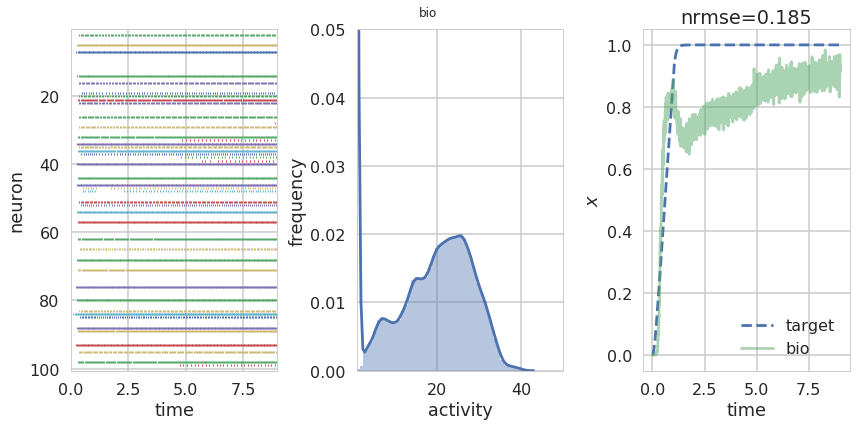

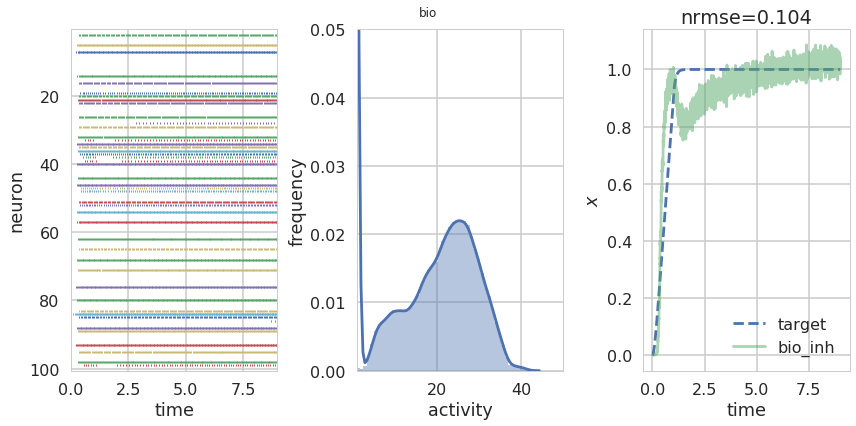

In [9]:
d_bio_out_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_out']
d_bio_bio_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_bio']
bias = Uniform(-7e-5, 7e-5)
n_neurons = 100
t = 9

inhibit_weights = np.random.RandomState(seed=1).uniform(
    -1e-5, -1e-5, size=((n_neurons, 100, 1)))

test_inh_fb(
    d_bio_out_good,
    d_bio_bio_good,
    sign=+1,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    inhibit_weights=inhibit_weights)

Building finished in 0:00:02.                                                   
Simulating finished in 0:45:19.                                                 


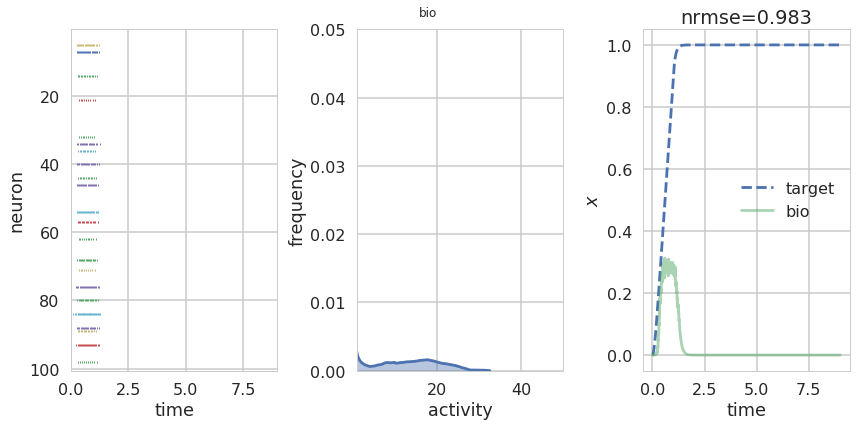

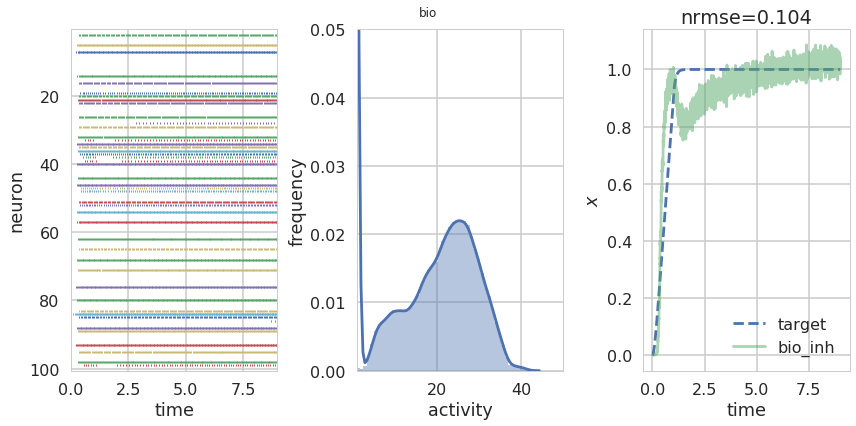

In [10]:
d_bio_out_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_out']
d_bio_bio_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_bio']
bias = Uniform(-7e-5, 7e-5)
n_neurons = 100
t = 9

inhibit_weights = np.random.RandomState(seed=1).uniform(
    -5e-5, -5e-5, size=((n_neurons, 100, 1)))

test_inh_fb(
    d_bio_out_good,
    d_bio_bio_good,
    sign=+1,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    inhibit_weights=inhibit_weights)

Building finished in 0:00:02.                                                   
Simulating finished in 0:44:50.                                                 


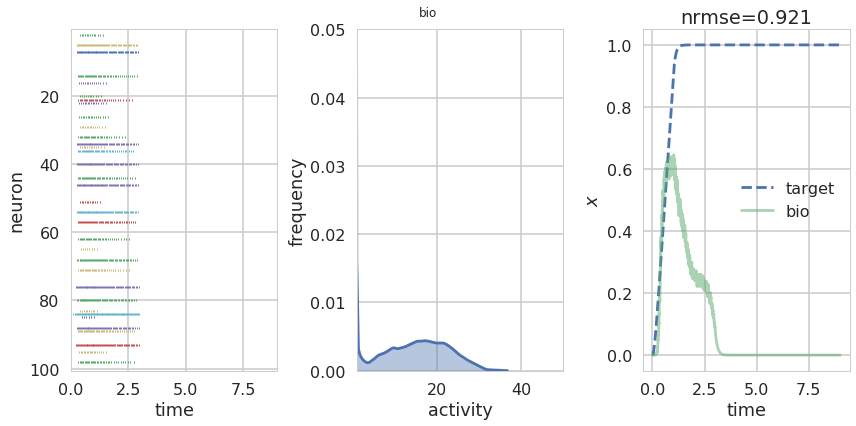

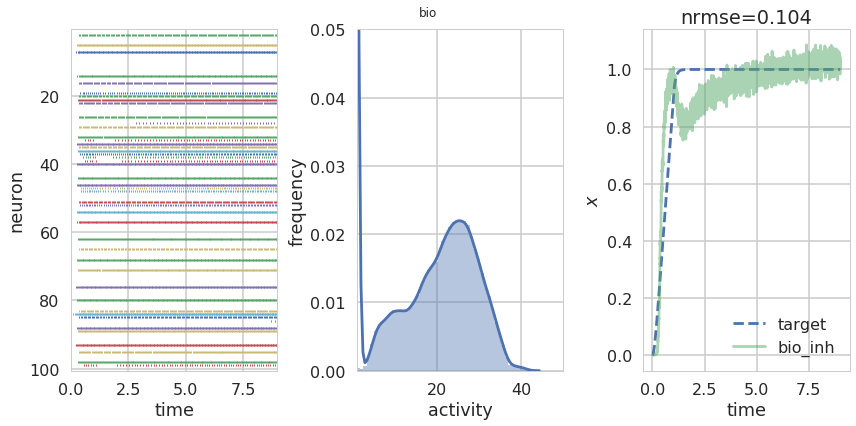

In [11]:
d_bio_out_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_out']
d_bio_bio_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_bio']
bias = Uniform(-7e-5, 7e-5)
n_neurons = 100
t = 9

inhibit_weights = np.random.RandomState(seed=1).uniform(
    -3e-5, -3e-5, size=((n_neurons, 100, 1)))

test_inh_fb(
    d_bio_out_good,
    d_bio_bio_good,
    sign=+1,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    inhibit_weights=inhibit_weights)

Building finished in 0:00:02.                                                   
Simulating finished in 0:48:13.                                                 


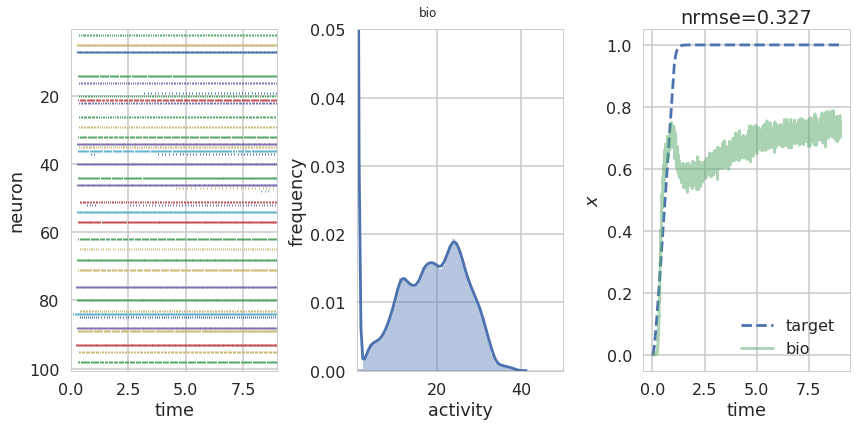

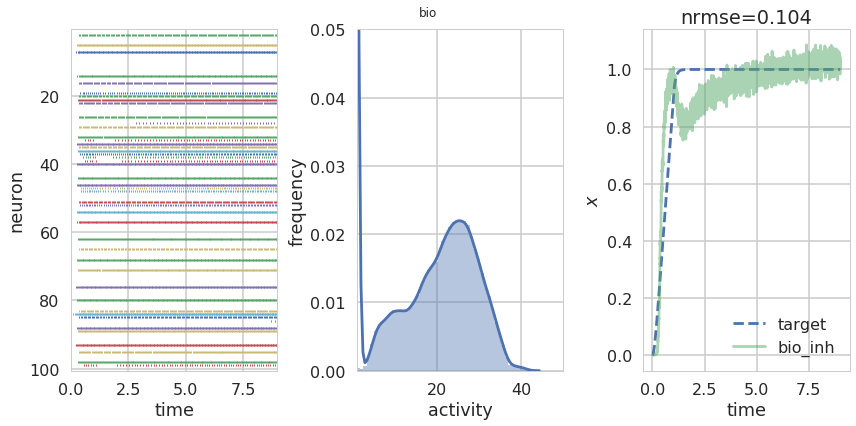

In [12]:
d_bio_out_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_out']
d_bio_bio_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_bio']
bias = Uniform(-7e-5, 7e-5)
n_neurons = 100
t = 9

inhibit_weights = np.random.RandomState(seed=1).uniform(
    -2e-5, -2e-5, size=((n_neurons, 100, 1)))

test_inh_fb(
    d_bio_out_good,
    d_bio_bio_good,
    sign=+1,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    inhibit_weights=inhibit_weights)

Building finished in 0:00:02.                                                   


/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


Simulating finished in 0:39:16.                                                 


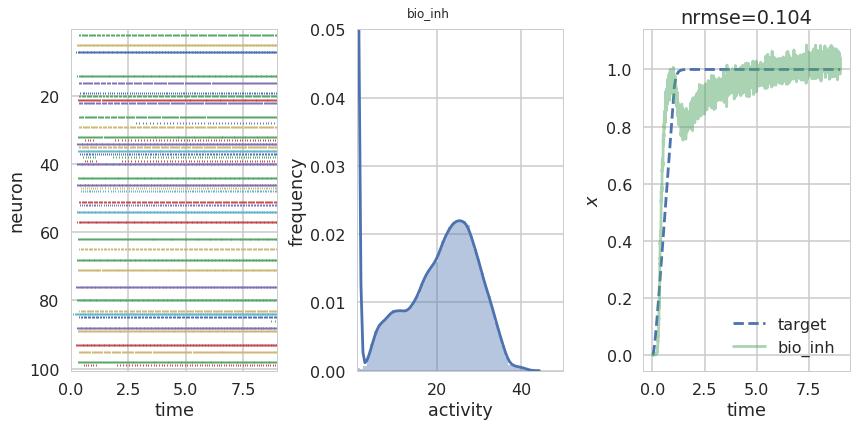

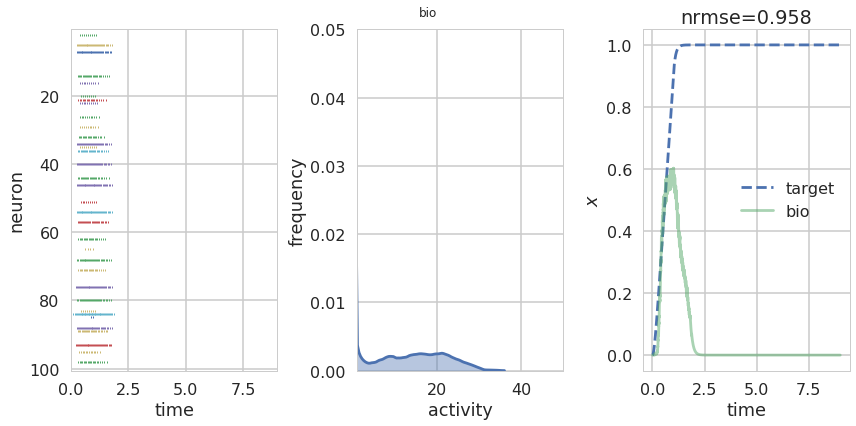

In [3]:
d_bio_out_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_out']
d_bio_bio_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_bio']
bias = Uniform(-7e-5, 7e-5)
n_neurons = 100
t = 9

inhibit_weights = np.random.RandomState(seed=1).uniform(
    -5e-5, -2e-5, size=((n_neurons, 100, 1)))

test_inh_fb(
    d_bio_out_good,
    d_bio_bio_good,
    sign=+1,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    inhibit_weights=inhibit_weights)

Building finished in 0:00:02.                                                   


/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


Simulating finished in 0:41:04.                                                 


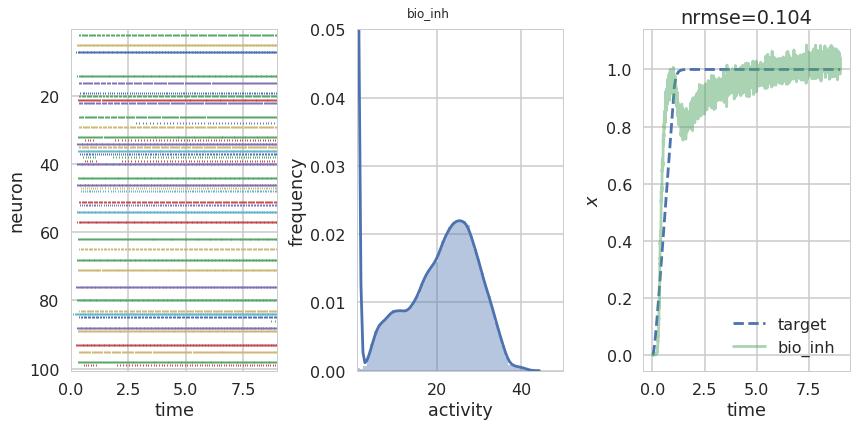

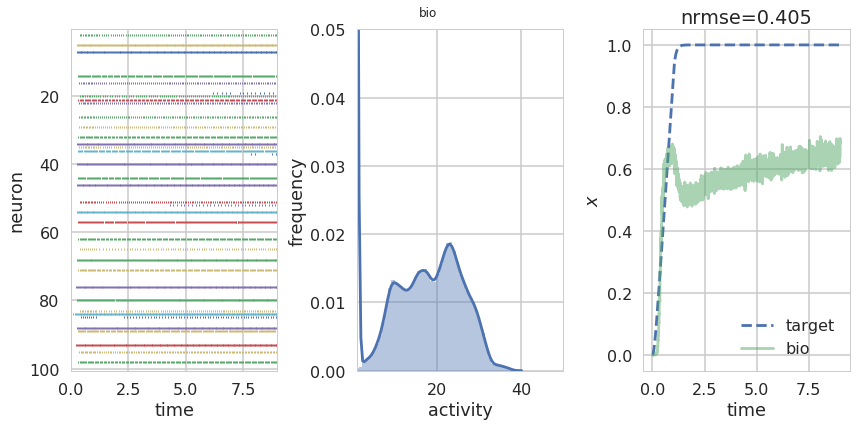

In [7]:
d_bio_out_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_out']
d_bio_bio_good = np.load('data/supvervise_integrator_7e-5bias.npz')['d_bio_bio']
bias = Uniform(-7e-5, 7e-5)
n_neurons = 100
t = 9

inhibit_weights = np.random.RandomState(seed=1).uniform(
    -2.5e-5, -2.5e-5, size=((n_neurons, 100, 1)))

test_inh_fb(
    d_bio_out_good,
    d_bio_bio_good,
    sign=+1,
    n_neurons=n_neurons,
    t=t,
    bias=bias,
    inhibit_weights=inhibit_weights)